## Import Python Libraries
#### Simply run next cell

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nd2reader import ND2Reader
from skimage.exposure import rescale_intensity
from cellpose import models
from skimage.segmentation import mark_boundaries
from skimage.filters import gaussian
from skimage.morphology import disk,white_tophat,disk,remove_small_objects
from skimage.measure import label,regionprops_table
import pandas as pd
import glob
import os

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


2022-02-02 17:32:58,804 [INFO] WRITING LOG OUTPUT TO /Users/robertwelch/.cellpose/run.log


## Define functions
#### Simply run next cell to define all functions

In [2]:
#Used to find max intensity projection of ND2 stack for cytoplasm and nuclei channels
def nd2_max_projection(nd2_object):
    #Get frame dimensions
    z_dim = nd2_object.sizes['z']
    x_dim = nd2_object.frame_shape[0]
    y_dim = nd2_object.frame_shape[1]
    stack = np.empty([z_dim,x_dim,y_dim])

    #Import all cytoplasm focal planes
    nd2_object.default_coords['c'] = 0 #Cyto Channel
    for z in range(z_dim):
        stack[z,:,:] = nd2_object[z]

    #Calculate maximum intensity projects for cyto channel
    max_intensity_cyto = np.amax(stack,axis=(0))

    #Import all nuclei focal planes
    nd2_object.default_coords['c'] = 1 #Nuclei Channel
    for z in range(z_dim):
        stack[z,:,:] = nd2_object[z]

    #Calculate maximum intensity projects for nuclei channel
    max_intensity_nuclei = np.amax(stack,axis=(0))

    #free up memory
    del stack
    nd2_object.close()

    return max_intensity_cyto,max_intensity_nuclei

#Used to import ND2 image stacks and return max, intensity projection of cytoplasm and nuclei channels
def import_stack(img_path,focal_plane_cyto=0,focal_plane_nuclei=0,min_percentile_cyto = 0,max_percentile_cyto = 100,min_percentile_nuclei = 0,max_percentile_nuclei = 100,max_intensity_projection = None):

  #Create nd2 image object
    nd2_object = ND2Reader(img_path)

  #If we want maximum projection images
    if max_intensity_projection == True:
        channel_cyto,channel_nuclei = nd2_max_projection (nd2_object)

  #If we want any focal plane
    else:
        #Import cytoplasm image at desired focal plane
        nd2_object.default_coords['c'] = 0
        channel_cyto = nd2_object[focal_plane_cyto]

        #Import nuclei image at desired focal plane
        nd2_object.default_coords['c'] = 1
        channel_nuclei = nd2_object[focal_plane_nuclei]
        nd2_object.close()


    channel_cyto_no_saturation =  channel_cyto

    #rescale cyto channel based on max and min cyto percentile limits
    v_min, v_max = np.percentile(channel_cyto, (min_percentile_cyto, max_percentile_cyto))
    channel_cyto = rescale_intensity(channel_cyto, in_range=(v_min, v_max))

    channel_nuclei_no_saturation = channel_nuclei

    #rescale nuclei channel based on max and min nuclei percentile limits
    v_min, v_max = np.percentile(channel_nuclei, (min_percentile_nuclei, max_percentile_nuclei))
    channel_nuclei = rescale_intensity(channel_nuclei, in_range=(v_min, v_max))

    #Create 3d array with with channel 0: cytoplasm, channel 1: nuclei
    output_stack = np.zeros([3,channel_cyto.shape[0],channel_cyto.shape[1]])
    output_stack[1,:,:] = channel_cyto
    output_stack[2,:,:] = channel_nuclei

    #Create 3d array with with channel 0: cytoplasm, channel 1: nuclei
    output_stack_no_saturation = np.zeros([3,channel_cyto.shape[0],channel_cyto.shape[1]])
    output_stack_no_saturation[1,:,:] = channel_cyto_no_saturation
    output_stack_no_saturation[2,:,:] = channel_nuclei_no_saturation

    #Convert to float32 for cellpose
    output_stack = (output_stack).astype(dtype = 'float32') 
    output_stack_no_saturation = (output_stack_no_saturation/65535.0).astype(dtype = 'float32')

    return output_stack,output_stack_no_saturation


#Segments the nucleus. Pass the 3D image stack and choose manual segmentation threshold for nuclei
def nuclei_segmentation(stack,thresh_nuclei=0.06,show_results = None):
    #Blur nuclei image
    nuclei_image = gaussian(stack[2,:,:],1)

    mask_nuclei = ((nuclei_image > thresh_nuclei)*1).astype('float32')

    if show_results == True:
        plt.figure(figsize = (20,5))
        plt.subplot(1,2,1)
        plt.imshow(stack[2,:,:])
        plt.title('Nuclei Channel')
        plt.colorbar()

        plt.subplot(1,2,2)
        plt.imshow(mask_nuclei)
        plt.title('Nuclei Channel')
    return mask_nuclei


#Function to segment the cells using Cellpose
def cell_segmentation(stack,diameter = 200,flow_threshold = 0,use_gpu = False,show_results = False):
    model = models.Cellpose(gpu=use_gpu, model_type='cyto',net_avg=False)
    mask_cyto, _, _, _ = model.eval(stack, diameter=diameter, flow_threshold=flow_threshold, channels=[2,3])
    if show_results == True:
        plt.figure(figsize = (15,15))
        segmentation_results = mark_boundaries(stack[1,:,:],mask_cyto)
        plt.imshow(segmentation_results)

    return mask_cyto


#Function to segment LC3 dots using white tophot and manual thresholding
def LC3_segmentation(stack,mask,threshold,tophat_size = 5,minimum_dot_size = 0,display_results = False):
    #image: raw max_intensity projection of cellular channel as input image (No image saturation works best)
    #mask: cytoplasm mask (no nuclei)
    #threshold: value to segment the proteins
    #plot_results: if true, will show images of steps
    # minimum_dot_size: removes leftover dots below this threshold area
    
    #Use cyto channel
    image = stack[1,:,:]

    #Smooth image
    image_guassian = gaussian(image,1)

    #Tophat morphological filter to supress large objects in image
    LC3_tophat = white_tophat(image_guassian,disk(tophat_size))

    #Manual Thresholding
    LC3_segmented = LC3_tophat > threshold   

    #Remove nuclei + out-of-cell dots
    LC3_segmented = LC3_segmented * mask

    #Removes dots below specified area if needed
    if minimum_dot_size > 0 :
        LC3_segmented = remove_small_objects(np.bool_(LC3_segmented),min_size = 3)

    #Show overlayed image if needed
    if display_results == True:
        
        segmentation_results = mark_boundaries(stack[1,:,:],np.bool_(LC3_segmented))
        plt.figure(figsize= (10,10))
        plt.imshow(segmentation_results)         
    return np.uint16(LC3_segmented)

# User Inputs

#### User inputs to adjust segmentation and thresholding results. #3 contains the most important parameters to refine the dot detection sensitivity.

In [3]:
#1. Enter the filepath of the folder containing the images to analyze
filepath = '/Users/robertwelch/Desktop/SciLifeLab Code/Chiara Project/Images'

#2. Run cell segmentation with GPU?:
use_gpu = False # if available, set to: True. Will automatically use CPU if no GPU found.

#3. Most Important Parameters to tune - LC3+ Detection parameters 
threshold_LC3 = 0.08 # Intensity threshold (Larger value results in less dots). Typical range: 0.03 - 0.2
minimum_dot_size = 10 # The minimum pixel area for a dot to be detected. Likely ~3-15

#4. Cellpose parameters, useful only if cellular segmentation is failing
cell_diameter = 200 #Estimate of cell_diamter - I find ~200 works well and is faster, despite being an overestimate
flow_threshold = 0 # Increase if cell segmentation if missing cells (usually around 0-0.9)

#5. Nuclei Segmentation, useful only if nuclei segmentation is failing
nuclei_threshold = 0.06 #simple manual nuclei threshold value.

#6. Image Export resolution
output_images = True #True or False. If True, will save segmentation results in Results folder. Will slow down processing.
resolution = 200 #pixels per inch. Higher resolution will result in slower processing and greater storage requirements.


## Run Program
##### Run the next cell to analyze all images in the specified directory.
##### Program will output a "Results" folder containing an excel sheet with protein counts for each cell in every image. Each excel element indicates the number of proteins within a single cell (ignoring the nuclei). 

##### Delete the existing results folder or change its name if you wish to re-run the program with diffferent parameters, otherwise it will add new results to existing folder.

Images Analyzed: 0
Analyzing: /Users/robertwelch/Desktop/SciLifeLab Code/Chiara Project/Images/WellB07_Channel Kinetix Single band EGFP, Kinetix Single  Hoechst_Seq0005.nd2
2022-02-02 17:35:58,755 [INFO] >>>> using CPU
2022-02-02 17:35:58,845 [INFO] ~~~ FINDING MASKS ~~~
2022-02-02 17:36:03,022 [INFO] >>>> TOTAL TIME 4.18 sec


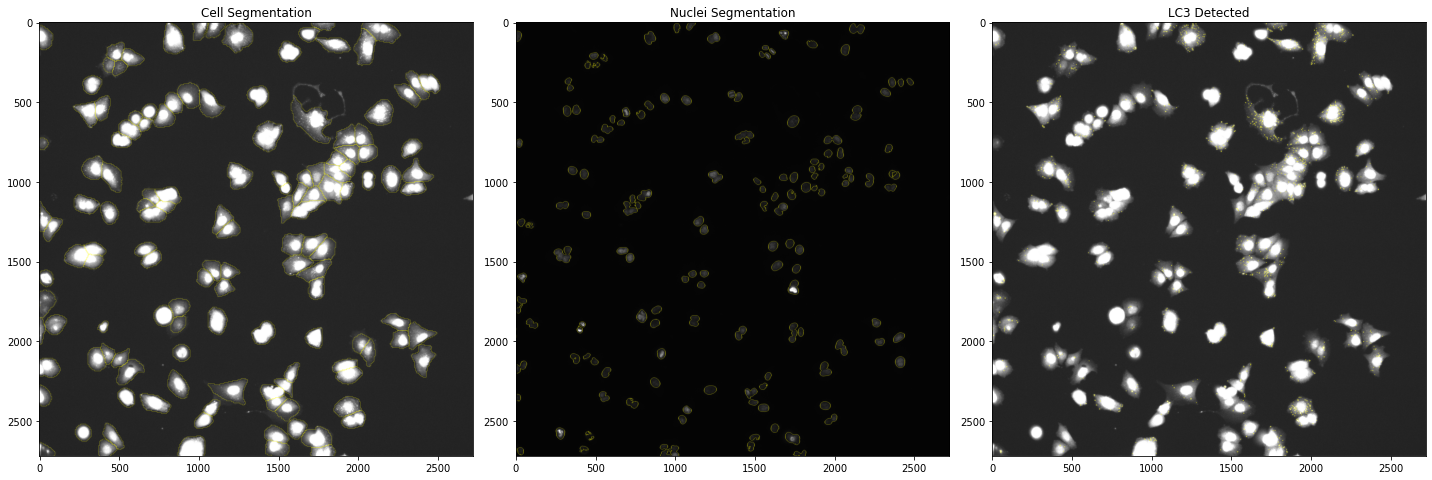

Images Analyzed: 1
Analyzing: /Users/robertwelch/Desktop/SciLifeLab Code/Chiara Project/Images/WellB05_Channel Kinetix Single band EGFP, Kinetix Single  Hoechst_Seq0003.nd2
2022-02-02 17:36:09,621 [INFO] >>>> using CPU
2022-02-02 17:36:09,712 [INFO] ~~~ FINDING MASKS ~~~
2022-02-02 17:36:13,652 [INFO] >>>> TOTAL TIME 3.94 sec


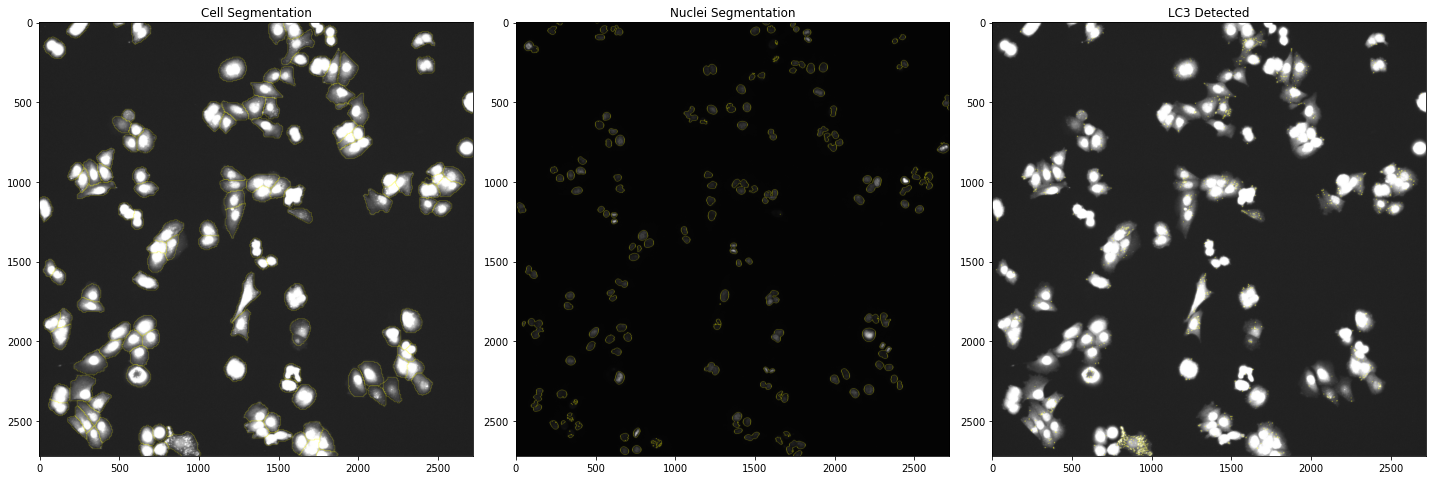

Images Analyzed: 2
Analyzing: /Users/robertwelch/Desktop/SciLifeLab Code/Chiara Project/Images/WellB08_Channel Kinetix Single band EGFP, Kinetix Single  Hoechst_Seq0006.nd2
2022-02-02 17:36:20,289 [INFO] >>>> using CPU
2022-02-02 17:36:20,380 [INFO] ~~~ FINDING MASKS ~~~
2022-02-02 17:36:24,364 [INFO] >>>> TOTAL TIME 3.98 sec


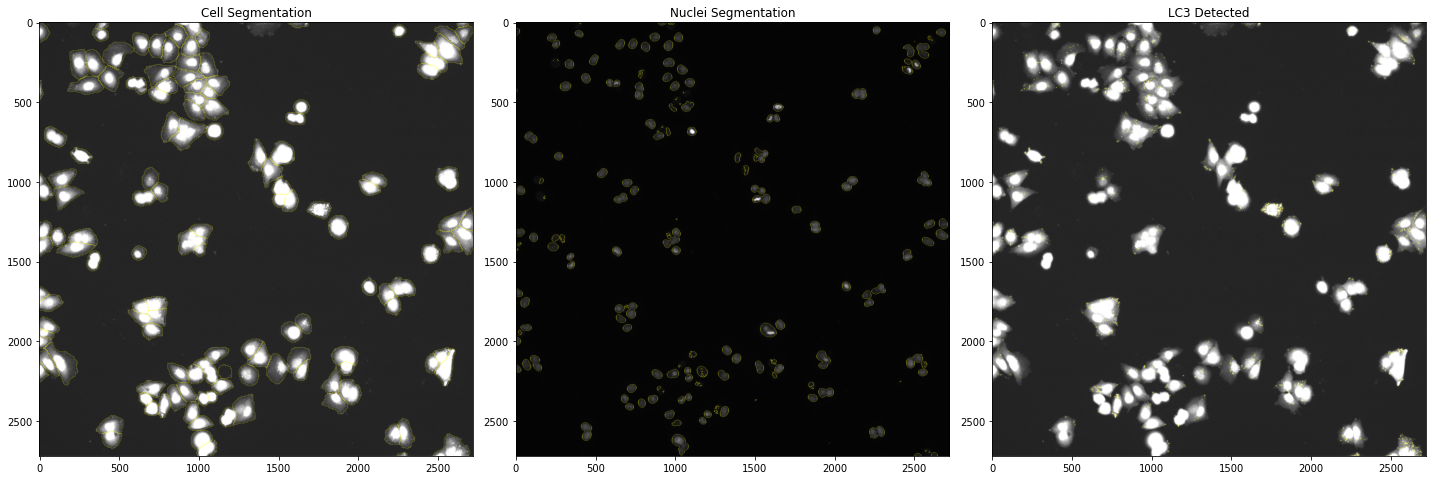

Images Analyzed: 3
Analyzing: /Users/robertwelch/Desktop/SciLifeLab Code/Chiara Project/Images/WellB10_Channel Kinetix Single band EGFP, Kinetix Single  Hoechst_Seq0008.nd2
2022-02-02 17:36:31,181 [INFO] >>>> using CPU
2022-02-02 17:36:31,269 [INFO] ~~~ FINDING MASKS ~~~
2022-02-02 17:36:35,555 [INFO] >>>> TOTAL TIME 4.29 sec


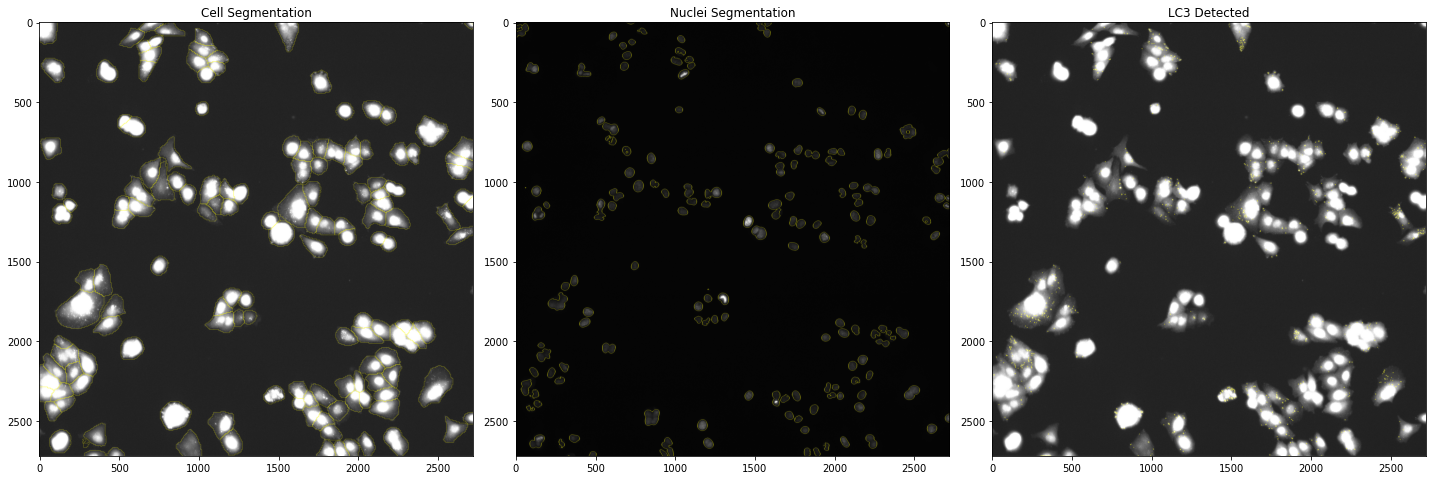

Images Analyzed: 4
Analyzing: /Users/robertwelch/Desktop/SciLifeLab Code/Chiara Project/Images/WellB03_Channel Kinetix Single band EGFP, Kinetix Single  Hoechst_Seq0001.nd2
2022-02-02 17:36:42,395 [INFO] >>>> using CPU
2022-02-02 17:36:42,484 [INFO] ~~~ FINDING MASKS ~~~
2022-02-02 17:36:46,745 [INFO] >>>> TOTAL TIME 4.26 sec


In [ ]:
pathND2 = filepath +'/*.nd2'
counter = 0
for filename in glob.glob(pathND2):
    print('Images Analyzed:',counter)
    print('Analyzing:',filename)
    counter += 1

    #Open Max Intensity Projection Image stack with formatting for cellpose
    #stack_with_sat has cytoplasm channel clipped to 95% max intensity, stack_without_sat does not
    stack_with_sat,stack_without_sat = import_stack(filename,min_percentile_cyto=0,max_percentile_cyto=95,min_percentile_nuclei=0,max_percentile_nuclei=100,max_intensity_projection=True)

    #Create Nuclei Mask
    mask_nuclei = nuclei_segmentation(stack_with_sat,thresh_nuclei=nuclei_threshold,show_results=False)

    #Create Cell Mask
    mask_cyto = cell_segmentation(stack_with_sat,diameter = cell_diameter,flow_threshold=flow_threshold,use_gpu = use_gpu,show_results = False)

    #Create cell mask with no nuclei
    net_mask = ((mask_cyto>0) - mask_nuclei)>0   

    #Segment the LC3+ dots
    LC3_segmented = LC3_segmentation(stack_with_sat,net_mask,threshold = threshold_LC3,minimum_dot_size=minimum_dot_size,display_results=False)
    labeled_LC3 = label(LC3_segmented)

    #Identify with cell LC3+ proteins appear in
    props = regionprops_table(labeled_LC3,mask_cyto,properties=('intensity_min','label'))

    #Convert regionprops results to pandas data frame and count number of LC3+ per cell
    data_holder = pd.DataFrame(props)
    data_holder = data_holder['intensity_min'].value_counts().reset_index()

    num_cells = np.amax(mask_cyto)
    num_cells_with_proteins = len(data_holder)
    cells_without_proteins = num_cells-num_cells_with_proteins
    
    #Add zeros for segmented cells with no detectable LC3 dots
    zero_pad = pd.DataFrame(np.zeros([cells_without_proteins,2]),columns=data_holder.columns)
    proteins_in_each_cell = pd.concat([data_holder,zero_pad],ignore_index = True)
    proteins_in_each_cell = proteins_in_each_cell['intensity_min'] # Only output number of proteins, discard cell ID label
    proteins_in_each_cell = pd.DataFrame(proteins_in_each_cell) #Re-format to Dataframe object
    
    #Results header string - uses last 4 numbers in .nd2 file name
    header = ['LC3+ Count: Image {0}'.format(filename[-8:-4])]

    #If First file, write an excel file to store excel results
    new_storage_directory = os.path.join(filepath, filepath+'/Results')
    results_path = new_storage_directory+'/LC3 Counts.xlsx'

    #Check if storage directory exits, if not make one
    if os.path.exists(new_storage_directory):
        pass  
    else:
        os.mkdir(new_storage_directory) 

    #create excel results file if it does not exist, otherwise write to existing
    if os.path.exists(results_path) is False:
        proteins_in_each_cell = proteins_in_each_cell.rename(columns={'intensity_min':header[0]})
        proteins_in_each_cell.to_excel(results_path,index = False,header = header[0])

    else:
        #Open Exisisting excel data
        existing_excel = pd.read_excel(results_path)

        #Add results of new image to existing results
        new_excel = pd.concat([existing_excel,proteins_in_each_cell],axis = 1,ignore_index=False)

        #Rename headers of new data
        new_excel = new_excel.rename(columns={'intensity_min':header[0]})

        #Write new file
        new_excel.to_excel(results_path,index = False)

    #Save Tiff. Image of results
    if output_images == True:
        fig,ax = plt.subplots(1,3)
        fig.set_size_inches(20,20)

        ax[0].imshow(mark_boundaries(stack_with_sat[1,:,:],mask_cyto))
        ax[0].set_title('Cell Segmentation')

        ax[1].imshow(mark_boundaries(stack_without_sat[2,:,:],label(mask_nuclei)))
        ax[1].set_title('Nuclei Segmentation')

        ax[2].imshow(mark_boundaries(stack_with_sat[1,:,:],labeled_LC3))
        ax[2].set_title('LC3 Detected')

        #If you want to speed up significantly, reduce dpi (resolution of images or comment out saving image results)
        plt.tight_layout()
        plt.savefig(new_storage_directory+'/results-{0}.tiff'.format(filename[-8:-4]),dpi = resolution)
        plt.show()

print('Finished, all images analyzed.')